# Sprint 7: Análisis estadístico para detectar patrones y outliers


## 🥅 **Objetivo de la sesión**
Ampliar las tecnicas de manipulación de datos "Data Wrangling" que hemos estudiado hasta ahora con "pandas".

1. Convertir columnas a tipo fecha/hora con `pd.to_datetime()` y solucionar formatos comunes.
2. Usar el *accessor* `.dt` para extraer partes de una fecha (año, mes, día, día de semana), redondear y crear features.
3. Identificar valores nulos (qué son y por qué aparecen) y aplicar 3 estrategias: **eliminar**, **imputar**, **flaggear**.
4. Explicar y calcular **media**, **mediana** y **moda**, e interpretar su comportamiento con datos sesgados y con outliers.
5. Construir una mini exploración con pandas para dejar datos “listos para análisis”.

---

## 🗂️ **Agenda de la sesión**

1. **Warm-up:** ¿Qué puede salir mal con fechas y nulos? (spoiler: todo)
2. **Fechas en Pandas (35–45 min)**
   - `pd.to_datetime()` (formatos, `errors`, `dayfirst`)
   - `.dt` (componentes, redondeo, periodos, tz)
   - Crear features de calendario

3. **Valores nulos (25–35 min)**
   - Qué es un nulo (NaN / None / NaT)
   - Detectar nulos
   - Estrategias: eliminar / imputar / flag

4. **Estadística básica: tendencia central (20–30 min)**
   - Media vs mediana vs moda
   - Outliers y sesgo (ejemplos e interpretación)
   
5. **Cierre (5 min):** checklist de limpieza + mini quiz

---

# Manejo de fechas en Pandas

## ¿Por qué las fechas dan problemas?
- Las fechas suelen venir como `string` (texto) con **formatos inconsistentes**:  
  `2026-01-24`, `24/01/2026`, `01-24-26`, `"January 24, 2026"`.
- Puede haber fechas imposibles o corruptas: `2026-13-01`, `"N/A"`.
- A veces hay zonas horarias (`UTC`, `America/Bogota`).

En pandas, cuando una columna es realmente fecha/hora, su tipo es:
- `datetime64[ns]` (fecha/hora)
- `datetime64[ns, tz]` (fecha/hora con zona horaria)
- `NaT` para fecha faltante (*Not a Time*).

---

## Convertir a fecha: `pd.to_datetime()`

>> **Regla de oro:** primero conviertes, luego usas `.dt`.

Parámetros útiles:
- `errors='coerce'`: lo que no pueda convertirse, queda como `NaT` (nulo de fecha).
- `dayfirst=True`: útil cuando el formato es `DD/MM/YYYY`.
- `format=...`: si conoces el formato exacto, es más rápido y más seguro.
- `utc=True`: parsea y convierte a UTC (útil con timestamps de logs).

Formatos comunes (`format=`):
- `'%Y-%m-%d'` → `2026-01-24`
- `'%d/%m/%Y'` → `24/01/2026`
- `'%m/%d/%Y'` → `01/24/2026`
- `'%Y-%m-%d %H:%M:%S'` → `2026-01-24 13:45:10`

---


In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('https://raw.githubusercontent.com/gbuvoli/Datasets/refs/heads/main/Online_Sales.csv')
display(df.sample(10))
df.info()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
27835,15311,33305,7/20/2019,GGOEGCNB021099,Seat Pack Organizer,Lifestyle,1,8.39,6.00,Clicked
43706,13168,41799,10/26/2019,GGOENEBQ081799,Nest Protect Smoke + CO White Wired Alarm - CA,Nest-Canada,3,104.00,8.70,Clicked
36482,16401,37395,9/5/2019,GGOEADWQ015699,Android Rise 14 oz Mug,Drinkware,1,10.39,6.00,Clicked
17503,14608,27753,5/11/2019,GGOEWEBB082699,Waze Mobile Phone Vent Mount,Waze,1,5.59,6.00,Clicked
43517,16222,41655,10/25/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,149.00,12.99,Clicked
45721,14290,43205,11/12/2019,GGOEGDHR018499,Google 22 oz Water Bottle,Drinkware,3,2.99,6.00,Clicked
4665,14723,19801,2/6/2019,GGOEGDWC020199,Engraved Ceramic Google Mug,Drinkware,6,8.99,6.50,Used
5100,15545,20094,2/10/2019,GGOEGAAQ010414,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,13.59,41.30,Clicked
17013,16779,27494,5/8/2019,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,3,119.00,12.99,Used
18333,17303,28185,5/16/2019,GGOEGBJC019999,Collapsible Shopping Bag,Bags,5,4.99,6.00,Clicked


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           52924 non-null  int64  
 1   Transaction_ID       52924 non-null  int64  
 2   Transaction_Date     52924 non-null  object 
 3   Product_SKU          52924 non-null  object 
 4   Product_Description  52924 non-null  object 
 5   Product_Category     52924 non-null  object 
 6   Quantity             52924 non-null  int64  
 7   Avg_Price            52924 non-null  float64
 8   Delivery_Charges     52924 non-null  float64
 9   Coupon_Status        52924 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 4.0+ MB


In [162]:
#Ajuste de tipos de datos
df['CustomerID'] = df['CustomerID'].astype('object')
df['Transaction_ID'] = df['Transaction_ID'].astype('object')

#Atencion con las fechas
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'], errors='coerce', format='%m/%d/%Y')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CustomerID           52924 non-null  object        
 1   Transaction_ID       52924 non-null  object        
 2   Transaction_Date     52924 non-null  datetime64[ns]
 3   Product_SKU          52924 non-null  object        
 4   Product_Description  52924 non-null  object        
 5   Product_Category     52924 non-null  object        
 6   Quantity             52924 non-null  int64         
 7   Avg_Price            52924 non-null  float64       
 8   Delivery_Charges     52924 non-null  float64       
 9   Coupon_Status        52924 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 4.0+ MB


In [163]:
#Validar cambios en el dataframe
df.head()

#¿Como se ve ahora Transaction_Date?

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used


## El *accessor* `.dt`: tu caja de herramientas
Una vez tengas una serie datetime (`df['fecha']`), puedes:
- Extraer partes:
  - `.dt.year`, `.dt.month`, `.dt.day`
  - `.dt.day_name()`, `.dt.month_name()`
  - `.dt.weekday` (0=lunes) / `.dt.isocalendar().week`

- Redondear y truncar:
  - `.dt.floor('D')` (baja al día)
  - `.dt.round('H')` (redondea a hora)

- Diferencias entre fechas:
  - `df['fecha_fin'] - df['fecha_ini']` → `timedelta`
  - `.dt.days` para obtener días

- Periodos:
  - `.dt.to_period('M')` para agrupar por mes (ej: cohortes / ventas mensuales)

---



In [164]:
#Explorando las fechas
df['Transaction_Date'].dt.year
df['Transaction_Date'].dt.month
df['Transaction_Date'].dt.month_name()
df['Transaction_Date'].dt.day
df['Transaction_Date'].dt.day_name()
df['Transaction_Date'].dt.hour
df['Transaction_Date'].dt.minute
df['Transaction_Date'].dt.weekday
df['Transaction_Date'].dt.quarter
df['Transaction_Date'].dt.is_month_end
df['Transaction_Date'].dt.is_month_start
df['Transaction_Date'].dt.is_quarter_end
df['Transaction_Date'].dt.is_quarter_start
df['Transaction_Date'].dt.is_year_end
df['Transaction_Date'].dt.is_year_start
df['Transaction_Date'].dt.days_in_month
df['Transaction_Date'].dt.is_leap_year



0        False
1        False
2        False
3        False
4        False
         ...  
52919    False
52920    False
52921    False
52922    False
52923    False
Name: Transaction_Date, Length: 52924, dtype: bool

In [165]:
#Creando nuevas columnas a partir de la fecha
df['Year'] = df['Transaction_Date'].dt.year
df['Month'] = df['Transaction_Date'].dt.month_name()
df['Day'] = df['Transaction_Date'].dt.day_name()
df['Quarter'] = df['Transaction_Date'].dt.quarter
df['weekday'] = df['Transaction_Date'].dt.weekday
df['period_month'] = df['Transaction_Date'].dt.to_period('M')
df['period_quarter'] = df['Transaction_Date'].dt.to_period('Q')
df.sample(10)

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Year,Month,Day,Quarter,weekday,period_month,period_quarter
43251,17236,41461,2019-10-23,GGOEGOAQ012899,Ballpoint LED Light Pen,Office,2,2.50,6.00,Not Used,2019,October,Wednesday,4,2,2019-10,2019Q4
15598,14911,26692,2019-04-28,GGOEGAEB084517,BLM Sweatshirt,Apparel,1,33.59,6.00,Used,2019,April,Sunday,2,6,2019-04,2019Q2
5757,18118,20498,2019-02-15,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,149.00,6.50,Used,2019,February,Friday,1,4,2019-02,2019Q1
36916,17064,37602,2019-09-07,GGOEAOCB077499,Android RFID Journal,Notebooks & Journals,1,4.80,32.18,Clicked,2019,September,Saturday,3,5,2019-09,2019Q3
38584,17576,38447,2019-09-19,GGOEGAAB033813,Google Men's Vintage Badge Tee Black,Apparel,3,7.60,12.91,Clicked,2019,September,Thursday,3,3,2019-09,2019Q3
34753,12868,36597,2019-08-25,GGOEGOCL077699,Google Hard Cover Journal,Notebooks & Journals,1,11.99,6.00,Used,2019,August,Sunday,3,6,2019-08,2019Q3
37534,14101,37929,2019-09-11,GGOEYAAB031813,YouTube Men's Short Sleeve Hero Tee Black,Apparel,2,16.99,6.00,Clicked,2019,September,Wednesday,3,2,2019-09,2019Q3
12433,15498,24969,2019-04-06,GGOEGOXQ016399,Badge Holder,Office,1,1.99,6.50,Clicked,2019,April,Saturday,2,5,2019-04,2019Q2
7950,18219,21969,2019-03-04,GGOEGAEJ030713,Google Men's 3/4 Sleeve Raglan Henley Grey,Apparel,1,24.99,6.50,Clicked,2019,March,Monday,1,0,2019-03,2019Q1
24148,14016,31413,2019-06-27,GGOEAAAP081215,Android Men's Take Charge Short Sleeve Tee Purple,Apparel,1,11.19,6.00,Clicked,2019,June,Thursday,2,3,2019-06,2019Q2


In [166]:
df.groupby(['Product_Category','Coupon_Status'])['sales_amount'].sum().unstack()

KeyError: 'Column not found: sales_amount'

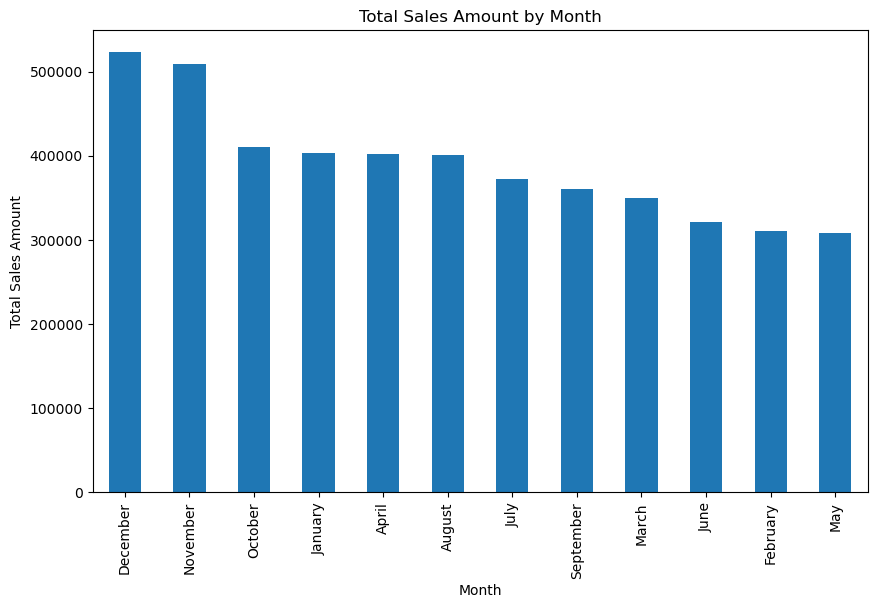

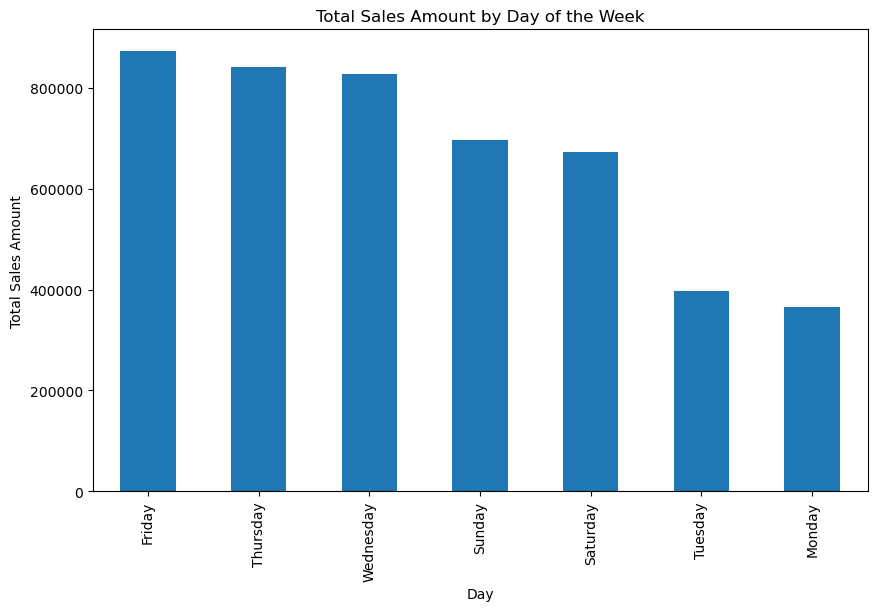

In [ ]:
#Ventas por mes
df['sales_amount'] = df['Quantity'] * df['Avg_Price']

df.groupby('Month')['sales_amount'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,6))
plt.title('Total Sales Amount by Month')
plt.ylabel('Total Sales Amount')
plt.show()

#Ventas por dia de la semana ¿Que dia es mejor para vender?
df.groupby('Day')['sales_amount'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,6))
plt.title('Total Sales Amount by Day of the Week')
plt.ylabel('Total Sales Amount')
plt.show()

## “Features” de calendario típicos
- `year`, `month`, `day`
- `day_of_week` (0–6)
- `is_weekend` (sábado/domingo)
- `hour` (si hay hora)
- `month_start`, `month_end`
- `week` (ISO week)
- `season`

# 2) Valores nulos (missing values)

## 2.1 ¿Qué es un nulo?
Es un valor **ausente**. En pandas puede aparecer como:
- `NaN` (numérico)
- `None` (objeto/texto)
- `NaT` (fechas)

Causas típicas:
- No se recolectó el dato
- Error en el proceso (ETL)
- Dato no aplica (ej: “edad” para una empresa)
- Fallo de parseo (por ejemplo, fecha inválida convertida con `errors='coerce'`)

---

## 2.2 Cómo detectar nulos
- `isna()` / `notna()`
- `df.isna().sum()` para conteo por columna
- `df[df['col'].isna()]` para ver filas afectadas

---

In [170]:
## Ejercicio: ¿Cuantos valores nulos hay en el dataset de la tienda de muebles online?

df= pd.read_csv('https://raw.githubusercontent.com/gbuvoli/Datasets/refs/heads/main/online_furniture_retailer.csv')
display(df.head())
df.info()

,product_category,product_subcategory,brand,delivery_status,assembly_service_requested,payment_method,order_id,customer_id,product_price,shipping_cost,assembly_cost,total_amount,delivery_window_days,customer_rating
0,Outdoor,Patio Set,World Market,Failed Delivery,True,Credit Card,93810,2824,191.27,45.63,86.82,323.72,11,3.2
1,Living Room,Sofa,West Elm,Cancelled,True,Apple Pay,13278,5506,702.87,52.65,183.07,938.59,10,4.5
2,Dining Room,Bar Stool,Ashley Furniture,Delivered,False,Cash on Delivery,42098,4657,395.41,96.79,0.00,492.20,2,NaN
3,Dining Room,China Cabinet,HomeGoods,Pending,False,Google Pay,28289,2679,602.59,0.00,0.00,602.59,9,NaN
4,Dining Room,China Cabinet,CB2,Pending,True,Apple Pay,98696,9935,1782.36,69.23,41.53,1893.12,13,1.3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938 entries, 0 to 1937
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_category            1938 non-null   object 
 1   product_subcategory         1938 non-null   object 
 2   brand                       1842 non-null   object 
 3   delivery_status             1938 non-null   object 
 4   assembly_service_requested  1938 non-null   bool   
 5   payment_method              1938 non-null   object 
 6   order_id                    1938 non-null   int64  
 7   customer_id                 1938 non-null   int64  
 8   product_price               1938 non-null   float64
 9   shipping_cost               1880 non-null   float64
 10  assembly_cost               1900 non-null   float64
 11  total_amount                1938 non-null   float64
 12  delivery_window_days        1938 non-null   int64  
 13  customer_rating             1658 

In [171]:
#Cuantos valores nulos hay por columna
df.isnull().sum()

product_category                0
product_subcategory             0
brand                          96
delivery_status                 0
assembly_service_requested      0
payment_method                  0
order_id                        0
customer_id                     0
product_price                   0
shipping_cost                  58
assembly_cost                  38
total_amount                    0
delivery_window_days            0
customer_rating               280
dtype: int64

In [172]:
# Nulos por columna en porcentaje
df.isnull().mean() * 100

product_category               0.000000
product_subcategory            0.000000
brand                          4.953560
delivery_status                0.000000
assembly_service_requested     0.000000
payment_method                 0.000000
order_id                       0.000000
customer_id                    0.000000
product_price                  0.000000
shipping_cost                  2.992776
assembly_cost                  1.960784
total_amount                   0.000000
delivery_window_days           0.000000
customer_rating               14.447884
dtype: float64

## 2.3 Tres estrategias (y cuándo usarlas)
### A) Eliminar (drop)
- **Útil** si:
  - son pocos nulos y no sesgan el análisis
  - la fila/columna no aporta valor
- **Riesgo**: puedes perder información y sesgar (si los nulos no son aleatorios).

### B) Imputar (fill)
Rellenas nulos con un valor razonable:
- Numérico: media/mediana (mediana suele ser más robusta a outliers)
- Categórico: moda o “Unknown”
- Fechas: un valor de referencia (ojo: esto puede introducir artefactos)

### C) Flaggear (crear indicador)
Creas una columna bandera:
- `col_was_missing` = 1 si faltaba, 0 si no.
- **Útil** cuando “faltar” es información valiosa (ej: si no puso teléfono, puede correlacionarse con abandono).

En la vida real, muchas veces haces **B + C**:
- imputas para poder modelar/analizar
- y guardas el flag para no perder señal

---

<Axes: >

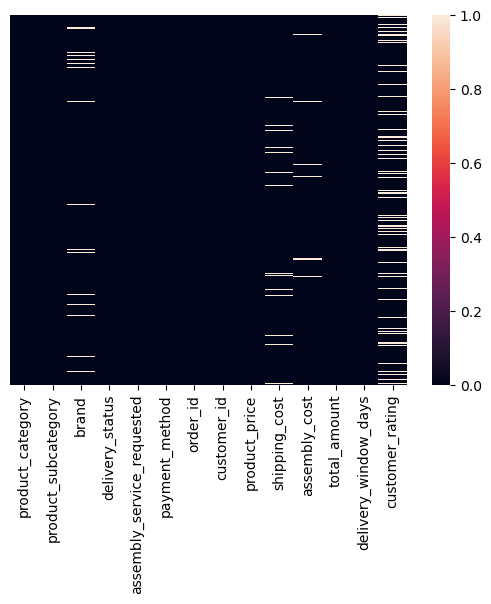

In [173]:
# Veamoslo gráficamente

sns.heatmap(df.isnull(),yticklabels=False, xticklabels=True)

* ¿Hay algún patrón en los nulos?, ¿Dependencia?, ¿Algúna relación que te ayude a decidir qué hacer con ellos?

In [174]:
#Estudiemos que hacer para cada columna con nulos

df[df['brand'].isnull()]

,product_category,product_subcategory,brand,delivery_status,assembly_service_requested,payment_method,order_id,customer_id,product_price,shipping_cost,assembly_cost,total_amount,delivery_window_days,customer_rating
29,Office,Bookshelf,NaN,Pending,True,Credit Card,96673,4733,142.60,50.02,116.16,308.78,8,2.7
65,Living Room,Armchair,NaN,Pending,True,Google Pay,79352,5119,1331.02,118.65,90.56,1540.23,5,NaN
70,Dining Room,China Cabinet,NaN,Failed Delivery,True,Apple Pay,24621,5808,1523.02,78.86,253.30,1855.18,12,2.1
99,Bedroom,Bed Frame,NaN,In Transit,True,Credit Card,42493,4681,2854.68,59.17,26.26,2940.11,6,1.5
111,Outdoor,Outdoor Table,NaN,Delivered,True,Apple Pay,27342,8744,1431.78,58.50,57.87,1548.15,10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1826,Kitchen,Pantry Cabinet,NaN,Cancelled,False,Cash on Delivery,67438,7875,2135.44,0.00,0.00,2135.44,10,NaN
1865,Outdoor,Garden Chair,NaN,Rescheduled,False,Bank Transfer,60793,4029,596.07,119.20,0.00,715.27,2,1.5
1866,Living Room,TV Stand,NaN,Delivered,True,Bank Transfer,58630,7249,2396.69,142.22,90.27,2629.18,9,5.0
1869,Office,Bookshelf,NaN,Cancelled,False,Bank Transfer,44510,8204,959.99,58.58,0.00,1018.57,1,NaN


In [175]:
# Revisemos cardinalidad de brand

print(df['brand'].value_counts())

#Podemos imputar una nueva categoria 'Unknown' para los nulos en brand

df.fillna({'brand':'Unknown'}, inplace=True)

#Validamos
print('Nulos en brand:', df['brand'].isnull().sum())

brand
Overstock           168
HomeGoods           165
World Market        160
CB2                 154
IKEA                154
West Elm            153
Pottery Barn        153
Ashley Furniture    152
Urban Outfitters    149
Crate & Barrel      146
Wayfair             145
Target              143
Name: count, dtype: int64
Nulos en brand: 0


In [176]:
#Estudiemos ahora shipping_cost

df[df['shipping_cost'].isnull()]

,product_category,product_subcategory,brand,delivery_status,assembly_service_requested,payment_method,order_id,customer_id,product_price,shipping_cost,assembly_cost,total_amount,delivery_window_days,customer_rating
5,Dining Room,Buffet,West Elm,Rescheduled,True,Bank Transfer,21395,7912,1307.80,NaN,170.18,1565.00,11,3.4
14,Outdoor,Lounge Chair,Overstock,In Transit,False,Bank Transfer,10851,3615,1712.30,NaN,0.00,1712.30,4,4.0
79,Living Room,TV Stand,Crate & Barrel,Failed Delivery,False,PayPal,31174,9837,1869.92,NaN,NaN,1977.91,14,NaN
165,Bedroom,Dresser,World Market,Cancelled,False,Google Pay,37938,9288,1726.69,NaN,0.00,1726.69,13,4.3
214,Kitchen,Kitchen Cabinet,Target,Pending,True,Bank Transfer,96511,4164,418.13,NaN,160.52,636.43,10,2.6
291,Living Room,Side Table,HomeGoods,Delivered,False,Google Pay,63424,6421,202.95,NaN,0.00,256.90,3,3.0
336,Office,Bookshelf,Ashley Furniture,Delivered,True,Bank Transfer,50888,7149,948.13,NaN,288.06,1374.19,2,2.8
338,Office,Bookshelf,Pottery Barn,In Transit,True,Credit Card,19961,4978,1022.47,NaN,41.08,1128.42,3,2.9
408,Living Room,TV Stand,Target,Delivered,False,Debit Card,83772,5978,1031.69,NaN,0.00,1100.41,4,4.8
410,Kitchen,Bar Cart,Overstock,In Transit,False,Apple Pay,25525,7818,2091.22,NaN,0.00,2221.63,14,1.6


In [177]:
#Esto no nos dice mucho, veamos estadísticos descriptivos y hagamos algunas segmentaciones de apoyo para decidir cómo imputar estos nulos

print(df['shipping_cost'].describe())



count    1880.000000
mean       69.622250
std        47.555003
min         0.000000
25%        32.585000
50%        74.055000
75%       107.735000
max       150.000000
Name: shipping_cost, dtype: float64


**Observación** Podemos ver que el costo de envío promedio es 69.62 con una desviación estándar de 47.55. La mediana es 74.05, lo que indica que la distribución está ligeramente sesgada a la izquierda. El valor mínimo es 0.0 y el máximo es 150, lo que sugiere que hay una amplia gama de costos de envío en el conjunto de datos.

**Conclusión** La imputación por promedio o mediana quizas no sea la mejor opción.

Analicemos más a fondo.. Quizás por categoría de producto o ventana de entrega

                  shipping_mean  shipping_median
product_category                                
Bedroom               69.530258           74.080
Dining Room           68.324608           70.910
Kitchen               68.526997           74.590
Living Room           66.743754           71.350
Office                69.455949           73.365
Outdoor               74.808278           80.930


Text(0.5, 1.0, 'Average Shipping Cost by Product Category')

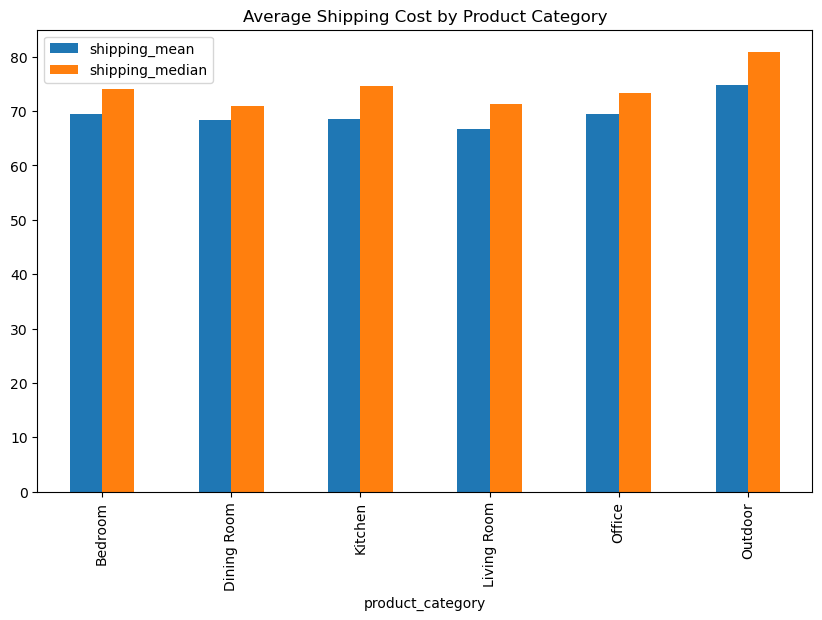

In [188]:
print(
    df.groupby('product_category')
      .agg(shipping_mean=('shipping_cost', 'mean'),
           shipping_median=('shipping_cost', 'median'))
)
df.groupby('product_category').agg(
    shipping_mean=('shipping_cost', 'mean'),
    shipping_median=('shipping_cost', 'median')).plot(kind='bar', figsize=(10,6))
plt.title('Average Shipping Cost by Product Category')

Vemos que las categorías tienen costos de envío promedio y medianos muy cercanos entre sí, excepto *outdoor* cuyo promedio es 74.8 y mediana es 80.9

**Decisión** Imputemos los nulos de "Shipping Cost" utilizando la mediana de la categoría a la que pertenece el producto.

In [189]:
# Imputemos los nulos de shipping_cost con la mediana por categoria de producto
medians = df.groupby('product_category')['shipping_cost'].median()

def impute_shipping_cost(row):
    if pd.isnull(row['shipping_cost']):
        return medians[row['product_category']]
    else:
        return row['shipping_cost']
    
df['shipping_cost'] = df.apply(impute_shipping_cost, axis=1)

#Validamos
print('Nulos en shipping_cost:', df['shipping_cost'].isnull().sum())

Nulos en shipping_cost: 0


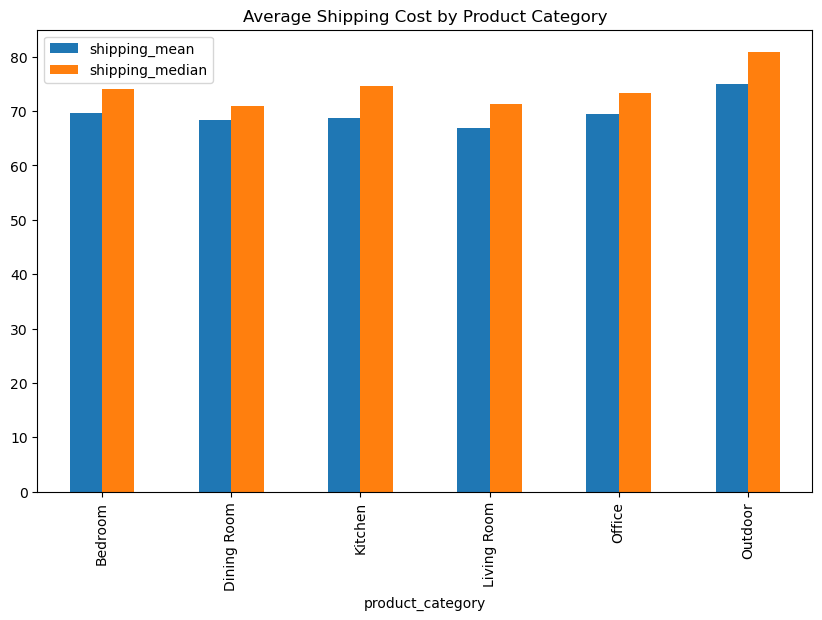

In [191]:
#Nuevo grafico por product_category tras la imputacion
df.groupby('product_category').agg(
    shipping_mean=('shipping_cost', 'mean'),
    shipping_median=('shipping_cost', 'median')).plot(kind='bar', figsize=(10,6))
plt.title('Average Shipping Cost by Product Category')
plt.show()

In [192]:
#Estudiemos que hacer para cada columna con nulos

df[df['assembly_cost'].isnull()]

,product_category,product_subcategory,brand,delivery_status,assembly_service_requested,payment_method,order_id,customer_id,product_price,shipping_cost,assembly_cost,total_amount,delivery_window_days,customer_rating
50,Office,Desk,HomeGoods,Delivered,True,Cash on Delivery,61856,8517,151.40,53.43,NaN,403.86,13,2.1
79,Living Room,TV Stand,Crate & Barrel,Failed Delivery,False,PayPal,31174,9837,1869.92,71.35,NaN,1977.91,14,NaN
101,Living Room,Coffee Table,Overstock,Failed Delivery,True,Google Pay,12757,4770,234.18,84.25,NaN,420.01,5,NaN
116,Living Room,Armchair,HomeGoods,Pending,False,Debit Card,56438,7939,247.97,49.36,NaN,297.33,14,2.4
130,Living Room,Armchair,Crate & Barrel,In Transit,False,PayPal,40982,3724,1037.89,146.96,NaN,1184.85,13,2.8
167,Office,Computer Table,World Market,Rescheduled,False,Debit Card,55745,2127,137.16,27.92,NaN,165.08,13,2.8
230,Outdoor,Garden Chair,Overstock,Failed Delivery,False,PayPal,67154,1027,724.74,128.43,NaN,853.17,6,2.8
284,Kitchen,Bar Cart,Ashley Furniture,Pending,False,Debit Card,40735,5451,1538.84,0.00,NaN,1538.84,9,3.0
297,Outdoor,Outdoor Table,Unknown,Failed Delivery,True,PayPal,72518,1096,300.38,65.81,NaN,554.74,6,1.2
319,Office,Office Chair,Urban Outfitters,Failed Delivery,True,Google Pay,43065,2341,748.16,108.36,NaN,1139.93,9,NaN


**Lógica** Podríamos pensar que el mismo producto - marca deberían tener el mismo costo de asembly, podríamos buscar referencias que sí tengan dato y usarlo para imputar.

In [201]:
df.groupby(['product_subcategory','brand'])['assembly_cost'].mean().unstack()

#Imputemos los nulos de assembly_cost con la media por subcategoria y marca
means = df.groupby(['product_subcategory','brand'])['assembly_cost'].mean()

#Creamos la función de imputación
def impute_assembly_cost(row):
    if pd.isnull(row['assembly_cost']):
        return means[row['product_subcategory'], row['brand']]
    else:
        return row['assembly_cost']

#Aplicamos la función
df['assembly_cost'] = df.apply(impute_assembly_cost, axis=1)

#Validamos
print('Nulos en assembly_cost:', df['assembly_cost'].isnull().sum())

Nulos en assembly_cost: 0


In [ ]:
#Estudiemos que hacer para customer_rating

df[df['customer_rating'].isnull()]

,product_category,product_subcategory,brand,delivery_status,assembly_service_requested,payment_method,order_id,customer_id,product_price,shipping_cost,assembly_cost,total_amount,delivery_window_days,customer_rating
2,Dining Room,Bar Stool,Ashley Furniture,Delivered,False,Cash on Delivery,42098,4657,395.41,96.79,0.00,492.20,2,NaN
3,Dining Room,China Cabinet,HomeGoods,Pending,False,Google Pay,28289,2679,602.59,0.00,0.00,602.59,9,NaN
6,Bedroom,Mattress,IKEA,Delivered,True,Apple Pay,14165,1488,1467.44,0.00,184.29,1651.73,13,NaN
12,Bedroom,Wardrobe,Target,Delivered,False,Debit Card,64987,4611,2867.47,141.85,0.00,3009.32,8,NaN
13,Living Room,Coffee Table,Crate & Barrel,In Transit,False,Debit Card,68878,5557,2219.42,58.57,0.00,2277.99,14,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1910,Kitchen,Pantry Cabinet,HomeGoods,Rescheduled,True,Cash on Delivery,14910,3821,852.89,62.06,200.83,1115.78,4,NaN
1915,Living Room,Side Table,Ashley Furniture,Pending,False,Apple Pay,16460,8785,465.51,55.49,0.00,521.00,14,NaN
1931,Kitchen,Bar Cart,Crate & Barrel,Rescheduled,True,Cash on Delivery,76426,7609,688.00,74.59,100.60,916.62,13,NaN
1935,Office,Desk,Ashley Furniture,Pending,True,Cash on Delivery,36309,1944,726.73,0.00,58.77,785.50,11,NaN


In [211]:
#Evaluemos los nulos por grupo de product_subcategory + brand

#Creamos una flag

df['rating_missing'] = df['customer_rating'].isnull().astype(int)

# Asignamos el promedio de rating por grupo por que cualquier otro numero, pero siempre haría los calculos oficiales usando el campo flag.

rating_means = df.groupby(['product_subcategory','brand'])['customer_rating'].mean()

def impute_customer_rating(row):
    if pd.isnull(row['customer_rating']):
        return rating_means[row['product_subcategory'], row['brand']]
    else:
        return row['customer_rating']

df['customer_rating'] = df.apply(impute_customer_rating, axis=1)

#Validamos
print('Nulos en customer_rating:', df['customer_rating'].isnull().sum())

Nulos en customer_rating: 0


## Estudiemos este otro caso:

In [214]:
df=pd.read_csv('https://raw.githubusercontent.com/gbuvoli/Datasets/refs/heads/main/Sales_outbound.csv',skip_blank_lines=True)
display(df.head())
df.info()

,Client_ID,Name,Age,Location,Income,TAX,previous sales_#,Type_of_Products,Contact_Channel,Contact_hour,Num_Contacts,Satisfaction_Score,Sales
0,1,NaN,51,FL,80000.0,12000.0,1,B,Email,5:30:00 AM,1,4,0
1,2,NaN,40,CA,82579.0,12387.0,5,A,Phone,4:45:00 PM,2,4,1
2,3,NaN,25,NY,58380.0,8757.0,3,C,Online Chat,6:30:00 AM,4,5,1
3,4,NaN,57,IL,75000.0,11250.0,0,A,Email,5:30:00 AM,3,2,0
4,5,NaN,61,CA,50049.0,7507.0,0,B,Email,9:00:00 AM,1,4,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Client_ID           1000 non-null   int64  
 1   Name                0 non-null      float64
 2   Age                 1000 non-null   int64  
 3   Location            1000 non-null   object 
 4   Income              996 non-null    float64
 5   TAX                 996 non-null    float64
 6   previous sales_#    1000 non-null   int64  
 7   Type_of_Products    1000 non-null   object 
 8   Contact_Channel     1000 non-null   object 
 9   Contact_hour        1000 non-null   object 
 10  Num_Contacts        1000 non-null   int64  
 11  Satisfaction_Score  1000 non-null   int64  
 12  Sales               1000 non-null   int64  
dtypes: float64(3), int64(6), object(4)
memory usage: 101.7+ KB


In [ ]:
#Nulos por columna
df.isna().sum()

Client_ID                0
Name                  1000
Age                      0
Location                 0
Income                   4
TAX                      4
previous sales_#         0
Type_of_Products         0
Contact_Channel          0
Contact_hour             0
Num_Contacts             0
Satisfaction_Score       0
Sales                    0
dtype: int64

**Observaciones**  

* La Columna name esta nula completamente.

* Solo hay 4 nulos en income y tax.

<Axes: >

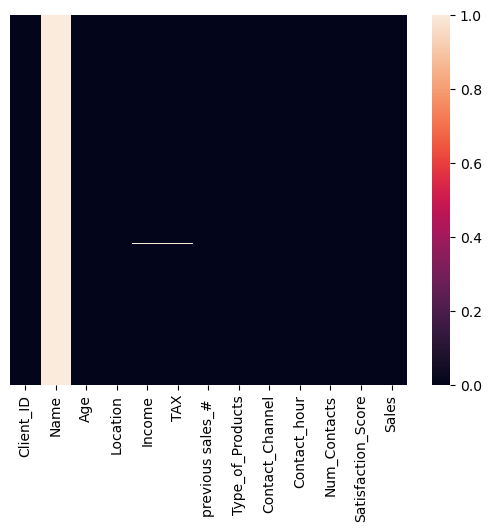

In [ ]:
#Inspección gráfica de nulos
sns.heatmap(df.isnull(), yticklabels=False, xticklabels=True)

**Observaciones**
Los nulos de `income`son los mismos de `tax`

* No hay forma de inferir esta información. Es mas seguro, eliminarla.
* La columna `Name`es irrelevante para nuestro análisis.

In [216]:
# Procedemos a eliminar las filas con nulos en *Income* y *TAX* ya que son pocas y no podemos imputar valores razonables
df.dropna(subset=['Income', 'TAX'], inplace=True)

#Eliminamos la columna *Name* que no aporta valor analítico
df.drop(columns=['Name'], inplace=True)

#Validamos
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 996 entries, 0 to 999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Client_ID           996 non-null    int64  
 1   Age                 996 non-null    int64  
 2   Location            996 non-null    object 
 3   Income              996 non-null    float64
 4   TAX                 996 non-null    float64
 5   previous sales_#    996 non-null    int64  
 6   Type_of_Products    996 non-null    object 
 7   Contact_Channel     996 non-null    object 
 8   Contact_hour        996 non-null    object 
 9   Num_Contacts        996 non-null    int64  
 10  Satisfaction_Score  996 non-null    int64  
 11  Sales               996 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 101.2+ KB


### RESUMEN:

El manejo de nulos depende exclusivamente del contexto de los datos:

De maneja general los datos ausentes se puede clasificar en:

* MCAR: Missing Completely at Random
* MAR: Missing at Random
* MNAR: Missing Not at Random




# Estadística básica: medidas de tendencia central

## 3.1 Media (promedio)
- Suma de valores / número de valores.
- **Sensibles a outliers**: un valor extremo la puede disparar.
- Buena para distribuciones “simétricas”.

## 3.2 Mediana
- Valor central al ordenar.
- **Robusta** a outliers.
- Muy usada en ingresos/precios (donde hay colas largas).

## 3.3 Moda
- Valor más frecuente.
- Útil con variables categóricas o discretas.

![](https://s1.significados.com/foto/media-mediana-moda-ejemplo-cke.jpg?class=article)

In [224]:
# =========================
# 1) Dataset simple (sin outliers)
# =========================
data_simple = [10, 12, 12, 13, 15, 16, 18]
s1 = pd.Series(data_simple, name="simple")

print("=== Dataset simple ===")
print("Datos:", data_simple)
print("Media  :", s1.mean())
print("Mediana:", s1.median())
print("Moda   :", list(s1.mode()))  # puede devolver varias modas

# =========================
# 2) Dataset con outlier (para ver el efecto en la media)
# =========================
data_outlier = [10, 12, 12, 13, 15, 16, 100]  # 100 es un outlier
s2 = pd.Series(data_outlier, name="outlier")

print("\n=== Dataset con outlier ===")
print("Datos:", data_outlier)
print("Media  :", s2.mean())
print("Mediana:", s2.median())
print("Moda   :", list(s2.mode()))


# =========================
# 3) Ejemplo con datos categóricos (moda como 'más frecuente')
# =========================
channels = ["web", "app", "web", "store", "web", "app", "web"]
s3 = pd.Series(channels, name="channel")

print("\n=== Categórico (moda) ===")
print("Datos:", channels)
print("Moda:", list(s3.mode()))  # aquí la moda tiene mucho sentido

print("\nConteo por categoría:")
print(s3.value_counts())


# =========================
# 4) Caso extra: cuando hay más de una moda (bimodal)
# =========================
data_bimodal = [1, 1, 2, 2, 3, 4, 5]
s4 = pd.Series(data_bimodal, name="bimodal")

print("\n=== Dataset bimodal (dos modas) ===")
print("Datos:", data_bimodal)
print("Media  :", s4.mean())
print("Mediana:", s4.median())
print("Moda   :", list(s4.mode()))


=== Dataset simple ===
Datos: [10, 12, 12, 13, 15, 16, 18]
Media  : 13.714285714285714
Mediana: 13.0
Moda   : [12]

=== Dataset con outlier ===
Datos: [10, 12, 12, 13, 15, 16, 100]
Media  : 25.428571428571427
Mediana: 13.0
Moda   : [12]

=== Categórico (moda) ===
Datos: ['web', 'app', 'web', 'store', 'web', 'app', 'web']
Moda: ['web']

Conteo por categoría:
channel
web      4
app      2
store    1
Name: count, dtype: int64

=== Dataset bimodal (dos modas) ===
Datos: [1, 1, 2, 2, 3, 4, 5]
Media  : 2.5714285714285716
Mediana: 2.0
Moda   : [1, 2]


## ¿Qué aprendimos hoy? 🧠

1. **Manejo de fechas** Considera si necesitas transformar (Si tu análisis tiene dimensión temporal.) Utiliza `pd.todatetime()` primero, y luego el *accesor*  `.dt` para manipular.

4. **Nulos:** `NaN`, `None` y `NaT` significan “dato ausente”, y puede ser por fallas de captura, no-aplica, o parsing. Antes de actuar, mide cuántos hay y en qué columnas.

5. **Estrategias de manejo de nulos, ninguna es “la correcta” en automático.**
   - **Eliminar** cuando son pocos y no sesgan.
   - **Imputar** cuando necesitas completar para análisis/modelos.
   - **Flaggear** cuando “estar ausente” podría explicar comportamiento (y muchas veces conviene combinar **imputar + flag**).

6. **Media y mediana cuentan historias distintas.**  
   - La **media** es sensible a outliers (puede inflarse con un valor extremo).  
   - La **mediana** es más robusta y suele representar mejor el “típico” cuando hay colas largas (ingresos, precios, revenue).



## Próxima clase ⏭️: Habilidades técnicas Python:

* Blucles
* Funciones
* Estructuras condicionales
* Aplicaciones en limpieza de dataframes

# Sesión Práctica 💪: Habilidades técnicas python

## 🎯 Objetivos de la sesión
Al final de esta clase podrás:

1. Explicar qué son **funciones**, **condicionales** (`if/elif/else`) y **bucles** (`for`, `while`) y cuándo conviene usarlos.
2. Escribir funciones simples para tareas típicas de limpieza (normalización, validación, categorización).
3. Aplicar condicionales para **reglas de negocio**
4. Iterar sobre listas/columnas/diccionarios para automatizar limpieza repetitiva.
5. Comparar enfoque “manual repetitivo” vs “función reutilizable”.

## 🧭 Agenda
1. **Contexto:** por qué Python “puro” importa aunque uses pandas.
2. **Condicionales:**
   - `if`, `elif`, `else`
   - validación y reglas de limpieza
3. **Bucles:**
   - `for` sobre listas/dicts
   - `while` para procesos repetidos (con cuidado)
4. **Funciones:**
   - `def`, parámetros, `return`
   - funciones para limpieza y calidad de datos
5. **Mini taller (15–20 min):** pipeline simple: limpiar + validar + generar flags

## Un poquito de teoría

### Condicionales (`if / elif / else`)
Sirven para **tomar decisiones**: ejecutar un bloque u otro dependiendo de una condición booleana (`True/False`).

**Estructura:**
- `if`: primera condición
- `elif`: condiciones alternativas (opcional, puede haber varias)
- `else`: caso por defecto (opcional)

**Uso típico en limpieza:**
- “Si es nulo → imputo”
- “Si el string tiene espacios → recorto”
- “Si no cumple formato → marco como inválido”

![](https://miro.medium.com/v2/resize:fit:1364/1*RDlB5cB2pk_302ODrX928g.png)


### Bucles (`for` y `while`)
Sirven para **repetir acciones**.

#### `for`
Itera sobre elementos de una colección: listas, diccionarios, rangos, etc.

**Uso típico en limpieza:**
- aplicar una regla a una lista de columnas
- recorrer registros y construir resultados
- evaluar múltiples condiciones o validaciones

#### `while`
Repite mientras una condición se cumpla.  
**Advertencia:** si no cambias la condición, haces un loop infinito (y el notebook se *frita*).

**Uso típico en limpieza:**
- reintentar un proceso hasta que cumpla una condición
- limpiar repetidamente hasta estabilizar (ej.: quitar espacios dobles hasta que no existan)

### Funciones
Una función es una pieza de código **reutilizable** que recibe entradas (parámetros) y devuelve una salida (`return`).

**Por qué importa en limpieza:**
- Evita copiar/pegar lógica (el enemigo #1 de la consistencia)
- Te permite aplicar reglas de forma uniforme
- Facilita pruebas: “si entra X, debe salir Y”

## PRÁCTICA

Los bucles `for` Se utilizan cuando tienes un bloque de codigo que quieres repetir un numero determinado de veces o quieres recorrer un elemento iterable

In [ ]:
# Imprimir números del 1 al 5

for i in [1, 2, 3, 4, 5]:
    print(i)


In [ ]:
# Imprimen cada letra de la frase "Hello world" un mensaje indicando el inicio y fin del ciclo
phrase="Hello world"
for letter in phrase:
  print('--inicia el ciclo, letter =', letter)
  print(' Aquí agregas cualquier operacion que quieras hacer')
  print('--fin del ciclo-------\n')

In [ ]:
# Saluda a los estudiantes de la siguiente lista
students = ["Ana", "Luis", "María", "Carlos", "Sofía"]
for student in students:
    print(f"Hola, {student}!")

In [ ]:
# Cambia a mayusculas los nombres de las columnas del dataframe

El ciclo while en Python permite ejecutar un bloque de código repetidamente mientras se cumpla una condición.

In [ ]:

contador = 0  # Variable de inicio

while contador < 5:  # Se ejecuta mientras el contador sea menor o igual a 5
    print("Inicia el ciclo, contador es:", contador)
    contador += 1  # Incremento para evitar un bucle infinito
    print("Termina el ciclo, contador es:", contador)
    print("---------------------------------")

In [ ]:
# Contar de 1 a 5
i = 1
while i <= 5:
    print(i)
    i = i + 1



In [ ]:
# Restar 1 hasta llegar a 0
x = 3
while x > 0:
    print("x =", x)
    x = x - 1
print("Listo, llegó a 0")

In [ ]:
# Sumar hasta pasar 10
total = 0
i = 1
while total <= 10:
    total = total + i
    i = i + 1
print("Total final:", total)

In [ ]:
edad = int(input("Ingrese su edad: "))

while edad <= 18:  # Se ejecuta mientras la edad sea inválida
    print(" Ud no tiene la edad autorizada para ingresar.")
    edad = int(input("Ingrese nuevamente su edad: "))

print("Edad registrada:", edad)

Condicionales if/elif/ else te permiten definir reglas para controlar la ejecución de tareas

In [ ]:
# IF-ELIF-ELSE 1) Nota: A/B/C/D
score = 73
if score >= 90:
    print("A")
elif score >= 80:
    print("B")
elif score >= 70:
    print("C")
else:
    print("D")

In [ ]:
# IF-ELIF-ELSE 2) Clasificar temperatura
temp = 30
if temp < 10:
    print("frío")
elif temp < 25:
    print("templado")
else:
    print("caliente")

In [ ]:
edad = int(input("Ingrese su edad: "))
estatura = float(input("Ingrese su estatura: "))

if edad >= 18: # if + condición + :
    print("Eres mayor de edad.") #Atención a la identación
    if estatura >= 1.80:
        print("Eres alto.")
    else:
        print("Eres bajo.")

elif edad >=13:
    print("Eres un adolescente.")

else: # No lleva condición porque es la "alternativa" al if
    print("Eres menor de edad.")


Las funciones son como "recetas de cocina", evita que repitas procesos y te ayuda a mantener la consistencia

In [ ]:
# Saludar
def greet(name):
    print("Hola", name)

greet("Gina")


In [ ]:
# FUNC 2) Sumar dos números
def add(a, b):
    return a + b

print("Suma:", add(2, 3))

In [ ]:
 #Par o impar
def is_even(x):
    return x % 2 == 0

print("Es par?", is_even(10))


¿Como podriamos combinar todo esto para limpiar datos?
* Crea funciones para: Explorar y limpiar datasets

In [ ]:
def convertir_columnas_numericas(df, columnas):
    for col in columnas:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

**RETO**   Crea una funcion que:
* seleccione las columnas numericas, calcule el porcentaje de nulos, y elimine las columnas con mas del 70%.
* Si tiene menos del 5%, elimine las filas con nulos.
* De lo contrario, impute con la mediana.

## ¿Qué aprendimos hoy? 🧠

* **Condicionales** (`if/elif/else`) permiten definir reglas.

* **Bucles** (`for, while`) sirven para automatizar tareas repetitivas:

    - `for` para recorrer colecciones (campos, columnas, reglas).

    - `while` para limpiar hasta cumplir una condición (usarlo con cuidado).

* **Funciones** convierten cualquier tarea en un sistema reutilizable
* **Integración con pandas:** puedes construir funciones en Python puro y aplicarlas a un dataframe con `.apply()`

## Próxima Semana ⏭️: 

* Análisis de distribuciones e histogramas
* Detección de outliers con el metodo de IQR y z-score
* Manipulación de outliers
* Segmentación de clientes con funciones y condicionales.
* GitHub